# Monet Style Transfer Using GANs

## Problem Description
Artists like Claude Monet are known for their distinct styles, characterized by unique brush strokes, color palettes, and composition. With the advancements in computer vision, Generative Adversarial Networks (GANs) have enabled the imitation of such artistic styles. 

In this project, the goal is to build a GAN that generates Monet-style images from scratch or transforms real-world photos into Monet-style art. The competition evaluates the quality of the generated images using MiFID (Memorization-informed Fréchet Inception Distance), a metric that assesses the similarity between generated and real Monet-style images.

### Objectives:
- Train a GAN to generate Monet-style images.
- Evaluate the model's performance using MiFID.
- Submit 7,000–10,000 Monet-style images for leaderboard evaluation.

---

## Data Description
The dataset contains images organized into four directories:

1. **monet_jpg**:
   - Contains 300 Monet paintings in JPEG format, each sized 256x256 pixels.
2. **monet_tfrec**:
   - Contains the same 300 Monet paintings, stored in TFRecord format.
3. **photo_jpg**:
   - Contains 7,028 real-world photos in JPEG format, each sized 256x256 pixels.
4. **photo_tfrec**:
   - Contains the same 7,028 photos, stored in TFRecord format.

### Data Format:
- **JPEG**: Standard image format for visualization and preprocessing.
- **TFRecord**: TensorFlow's optimized format for efficient data handling.

For this project, we will use the JPEG files for simplicity and visualization. TFRecords may be used for advanced training optimization.

---

## Exploratory Data Analysis (EDA)
EDA involves understanding the structure, distribution, and visual characteristics of the dataset. The following steps are performed:

1. **Dataset Summary**:
   - Count the number of images in the `monet_jpg` and `photo_jpg` directories.

2. **Visualization**:
   - Display sample images from the Monet paintings and photo datasets to understand the style gap between the two domains.

3. **Image Properties**:
   - Verify image dimensions (all images should be 256x256).
   - Confirm the presence of RGB channels in all images.

4. **Insights**:
   - Highlight key differences in style between Monet paintings and real-world photos.

The findings from this step will inform the design of the GAN model and preprocessing pipeline.


In [1]:
# Import necessary libraries
import os
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf


Number of Monet images: 300
Number of photo images: 7038


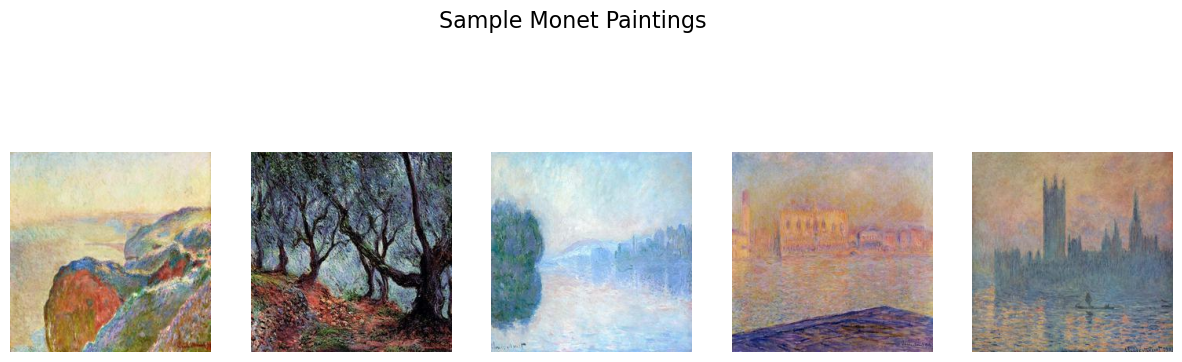

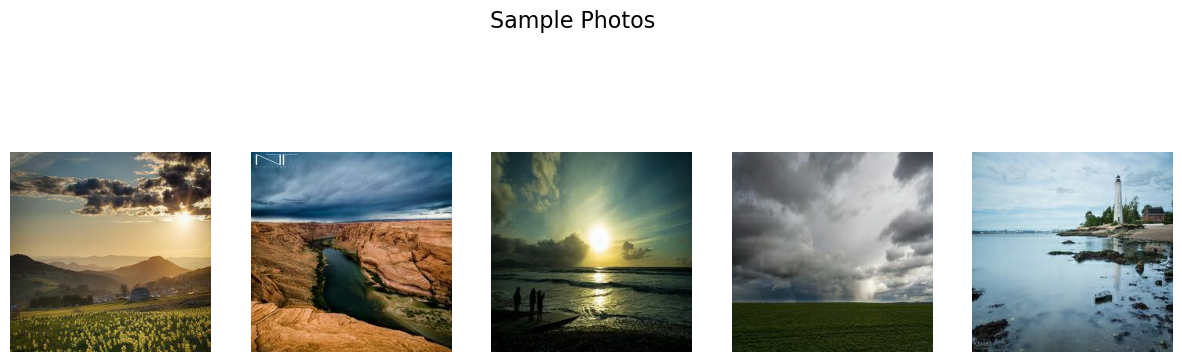

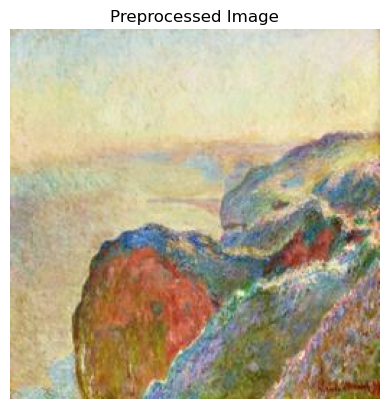

In [2]:
# Define dataset paths
DATA_PATH = "Data/"
#DATA_PATH = "/kaggle/input/gan-getting-started/monet_jpg"
MONET_PATH = os.path.join(DATA_PATH, "monet_jpg")
PHOTO_PATH = os.path.join(DATA_PATH, "photo_jpg")

# Load and explore the data
def load_image_paths(folder):
    return [os.path.join(folder, img) for img in os.listdir(folder) if img.endswith(".jpg")]

monet_images = load_image_paths(MONET_PATH)
photo_images = load_image_paths(PHOTO_PATH)

print(f"Number of Monet images: {len(monet_images)}")
print(f"Number of photo images: {len(photo_images)}")

# Visualize sample images
def display_images(image_paths, title, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        img = Image.open(image_paths[i])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

display_images(monet_images, "Sample Monet Paintings")
display_images(photo_images, "Sample Photos")

# Preprocess the data
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return img

# Example of preprocessing one image
sample_img = preprocess_image(monet_images[0])
plt.imshow((sample_img + 1) / 2)  # Normalize back to [0, 1] for display
plt.axis("off")
plt.title("Preprocessed Image")
plt.show()

# Convert all images to TensorFlow datasets
monet_ds = tf.data.Dataset.from_tensor_slices(monet_images).map(preprocess_image)
photo_ds = tf.data.Dataset.from_tensor_slices(photo_images).map(preprocess_image)


In [3]:
#Data Augmentation
#Data augmentation involves applying transformations to your dataset to artificially increase its size and diversity. This is especially useful 
#when working with limited data (e.g., only 300 Monet paintings).

#Why Augmentation is Helpful:

#- It prevents the model from overfitting to the small training dataset.
#- It provides more variety, making the model robust to variations in input images.

def augment_image(image):
    image = tf.image.random_flip_left_right(image)  # Horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast
    return image


In [4]:
#Dataset Batching
#Batching involves grouping a fixed number of images into "batches" that the model processes together in one forward/backward pass during training.

#Why Batching is Helpful:

#- It balances the trade-off between computational efficiency and model performance.
#- It reduces memory usage compared to loading all images at once.
#- It speeds up training by enabling vectorized operations.

#Batching Workflow:

#- Load images into a tf.data.Dataset.
#- Apply preprocessing and augmentation transformations.
#- Combine images into batches of a fixed size (e.g., 32 or 64).

# Combine augmentation and batching into the dataset pipeline
batch_size = 32

train_dataset = (
    monet_ds  # Start with the Monet dataset
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentation
    .batch(batch_size)  # Group images into batches
    .prefetch(tf.data.AUTOTUNE)  # Optimize performance by prefetching batches
)


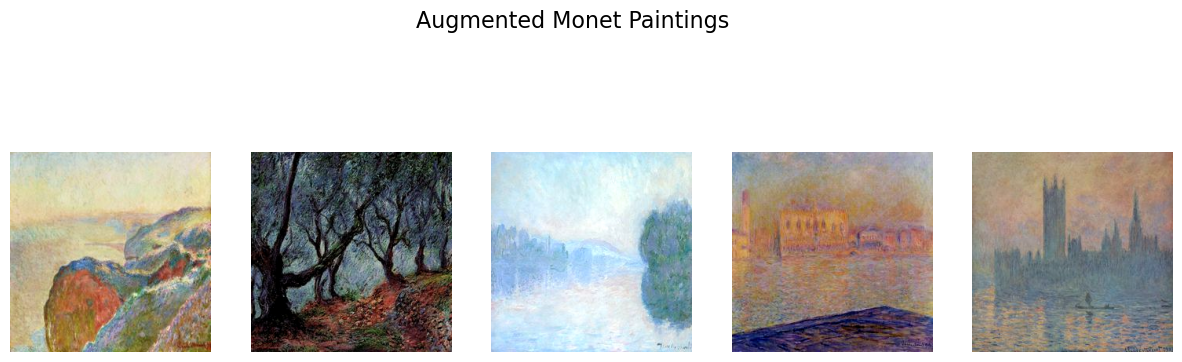

In [8]:
# Visualize preprocessed and augmented images from the dataset
def visualize_augmented_samples(dataset, title, n=5):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(dataset.take(n)):
        image = (image.numpy() + 1) / 2  # Scale to [0, 1]
        image = tf.clip_by_value(image, 0, 1)  # Ensure values are within [0, 1]
        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualize 5 augmented samples
visualize_augmented_samples(train_dataset.unbatch(), "Augmented Monet Paintings")


## Building the GAN Architecture

To generate Monet-style paintings, we utilize a Generative Adversarial Network (GAN). For this project, we adopt a **CycleGAN architecture**, which is specifically designed for unpaired image-to-image translation tasks.

### Generator
The **generator** is responsible for transforming photos into Monet-style paintings (or vice versa). It is designed to:
- Capture complex patterns and features of Monet paintings.
- Generate visually convincing Monet-style images.

The generator model architecture typically resembles a **U-Net** with added **residual blocks**, which allow the network to preserve important features while learning transformations.

### Discriminator
The **discriminator** determines whether an image is a real Monet painting or a generated Monet-style image. It is trained to:
- Accurately classify real versus fake images.
- Help the generator improve over time by providing meaningful feedback.

The discriminator model employs a **PatchGAN** architecture, which classifies individual patches of an image as real or fake rather than evaluating the entire image at once. This design improves the model's ability to focus on fine-grained details.


In [7]:
# Import additional libraries
from tensorflow.keras import layers

# Generator Model
def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))
    
    # Encoder
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    # Residual blocks
    for _ in range(6):
        res = layers.Conv2D(64, kernel_size=3, padding="same")(x)
        res = layers.ReLU()(res)
        res = layers.Conv2D(64, kernel_size=3, padding="same")(res)
        x = layers.add([x, res])  # Skip connection
    
    # Decoder
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(3, kernel_size=7, padding="same", activation="tanh")(x)
    
    return tf.keras.Model(inputs, x, name="Generator")

# Discriminator Model
def build_discriminator():
    inputs = layers.Input(shape=(256, 256, 3))
    
    # Convolutional layers
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    x = layers.Conv2D(1, kernel_size=4, padding="same")(x)
    
    return tf.keras.Model(inputs, x, name="Discriminator")

# Instantiate models
generator = build_generator()
discriminator = build_discriminator()

# Display model summaries
generator.summary()
discriminator.summary()


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      3,136 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 128, 128,  │          0 │ conv2d_18[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │     36,928 │ leaky_re_lu_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 128, 128,  │          0 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ re_lu_7[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 128, 128,  │          0 │ leaky_re_lu_4[0]… │
│                     │ 64)               │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     36,928 │ add_6[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 128, 128,  │          0 │ add_6[0][0],      │
│                     │ 64)               │            │ conv2d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │     36,928 │ add_7[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 128, 128,  │          0 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │     36,928 │ re_lu_9[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 128, 128,  │          0 │ add_7[0][0],      │
│                     │ 64)               │            │ conv2d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │     36,928 │ add_8[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 128, 128,  │          0 │ conv2d_25[0][0] 

 Total params: 521,283 (1.99 MB)

 Trainable params: 521,283 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 32, 32, 1)      │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define loss functions
# Adversarial loss: Binary crossentropy
binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

def generator_loss(fake_output):
    return binary_crossentropy(tf.ones_like(fake_output), fake_output)

# Cycle-consistency loss: L1 loss
def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

# Identity loss: L1 loss
def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))


In [10]:
# Define optimizers
learning_rate = 2e-4
beta_1 = 0.5

generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1)


In [11]:
@tf.function
def train_step(real_photo, real_monet):
    # Persistent GradientTape for multiple operations
    with tf.GradientTape(persistent=True) as tape:
        # Generate Monet-style image and reconstructed photo
        fake_monet = generator(real_photo, training=True)
        cycled_photo = generator(fake_monet, training=True)
        
        # Generate photo from Monet and reconstructed Monet
        fake_photo = generator(real_monet, training=True)
        cycled_monet = generator(fake_photo, training=True)
        
        # Discriminator predictions
        disc_real_monet = discriminator(real_monet, training=True)
        disc_fake_monet = discriminator(fake_monet, training=True)
        
        # Losses
        gen_loss = generator_loss(disc_fake_monet)
        cycle_loss = cycle_consistency_loss(real_photo, cycled_photo) + cycle_consistency_loss(real_monet, cycled_monet)
        total_gen_loss = gen_loss + (10.0 * cycle_loss)  # Weighted cycle-consistency
        
        disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
    
    # Gradients for generators and discriminators
    generator_gradients = tape.gradient(total_gen_loss, generator.trainable_variables)
    discriminator_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_loss, cycle_loss, disc_loss


In [12]:
# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for real_photo, real_monet in dataset:
            gen_loss, cycle_loss, disc_loss = train_step(real_photo, real_monet)
        
        # Log losses
        print(f"Generator Loss: {gen_loss.numpy()}, Cycle Loss: {cycle_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")


In [13]:
# Batch and zip datasets
batch_size = 32

photo_batches = photo_ds.batch(batch_size)
monet_batches = monet_ds.batch(batch_size)

# Combine the datasets
train_dataset = tf.data.Dataset.zip((photo_batches, monet_batches))


In [15]:
def visualize_generated_images(generator, real_photo_batch, epoch):
    # Generate Monet-style paintings
    fake_monet_batch = generator(real_photo_batch, training=False)
    
    # Visualize
    plt.figure(figsize=(15, 15))
    for i in range(5):  # Show 5 images
        # Real photo
        plt.subplot(3, 5, i + 1)
        plt.imshow((real_photo_batch[i].numpy() + 1) / 2)
        plt.title("Real Photo")
        plt.axis("off")
        
        # Generated Monet-style painting
        plt.subplot(3, 5, i + 6)
        plt.imshow((fake_monet_batch[i].numpy() + 1) / 2)
        plt.title("Generated Monet")
        plt.axis("off")
    
    plt.suptitle(f"Generated Images at Epoch {epoch}", fontsize=16)
    plt.show()


In [16]:
def train_with_visualization(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for real_photo, real_monet in dataset:
            gen_loss, cycle_loss, disc_loss = train_step(real_photo, real_monet)
        
        # Log losses
        print(f"Generator Loss: {gen_loss.numpy()}, Cycle Loss: {cycle_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")
        
        # Visualize outputs at the end of the epoch
        sample_batch = next(iter(photo_ds.batch(5)))  # Take a small batch of real photos
        visualize_generated_images(generator, sample_batch, epoch+1)


In [18]:
# Save generator and discriminator
generator.save("generator.keras")
discriminator.save("discriminator.keras")


In [19]:
# Load generator and discriminator using the new format
generator = tf.keras.models.load_model("generator.keras")
discriminator = tf.keras.models.load_model("discriminator.keras")


In [20]:
# Checkpointing
checkpoint_dir = "./checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator)

def train_with_checkpoints(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for real_photo, real_monet in dataset:
            gen_loss, cycle_loss, disc_loss = train_step(real_photo, real_monet)
        
        # Save checkpoint at the end of each epoch
        checkpoint.save(file_prefix=checkpoint_prefix)
        
        # Visualize outputs at the end of the epoch
        sample_batch = next(iter(photo_ds.batch(5)))  # Take a small batch of real photos
        visualize_generated_images(generator, sample_batch, epoch+1)


In [21]:
# Define output directory for generated images
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

# Generate and save Monet-style images
def generate_and_save_images(generator, dataset, output_dir):
    print(f"Generating images and saving to {output_dir}...")
    count = 0
    for photo_batch in dataset:
        generated_images = generator(photo_batch, training=False)
        generated_images = ((generated_images + 1) / 2).numpy()  # Scale to [0, 1]
        
        for i, image_array in enumerate(generated_images):
            # Convert to uint8 format for saving
            image = (image_array * 255).astype("uint8")
            image_pil = Image.fromarray(image)
            
            # Save as JPEG
            image_pil.save(os.path.join(output_dir, f"image_{count + i}.jpg"))
        
        count += len(photo_batch)
        if count >= 10000:  # Stop if 10,000 images are generated
            break
    print(f"Generated {count} images.")

# Generate images using the photo dataset
generate_and_save_images(generator, photo_ds.batch(32), output_dir)


Generating images and saving to generated_images...
Generated 7038 images.


In [23]:
# Compress the images into a zip file
def create_submission_zip(output_dir, zip_file_name):
    print(f"Compressing images in {output_dir} to {zip_file_name}...")
    with zipfile.ZipFile(zip_file_name, "w") as zipf:
        for root, _, files in os.walk(output_dir):
            for file in files:
                if file.endswith(".jpg"):
                    file_path = os.path.join(root, file)
                    zipf.write(file_path, os.path.relpath(file_path, output_dir))
    print(f"Created {zip_file_name}.")

# Create the submission zip file
zip_file_name = "images.zip"
#zip_file_namwe = "/kaggle/working/images.zip"
create_submission_zip(output_dir, zip_file_name)


Compressing images in generated_images to images.zip...
Created images.zip.


In [2]:
# Define the directory to delete
generated_images_dir = "generated_images"

# Check if the directory exists and delete it
if os.path.exists(generated_images_dir) and os.path.isdir(generated_images_dir):
    shutil.rmtree(generated_images_dir)
    print(f"Deleted folder: {generated_images_dir}")
else:
    print(f"Folder not found: {generated_images_dir}")


Deleted folder: generated_images
